#A Pragmatic Introduction to Perceptual Vector Quantization (part 2)
###Luc Trudeau

## Context
The objective of this notebook is to give insight into the inner working of Perceptual Vector Quantization (PVQ). More specifically in part 2, we focus on a perceptually vector quantizing an image. To do so, we will need to perform:
 * Discrete cosine transform
 * Raster to ZigZag
 * PVQ
 * ZigZag to Raster
 * Inverse discrete cosine transform

Let's start by doing all that on a 4x4 block and we will move on to a full image after that.

##Humble beginnings, a 4x4 block
Let's start by loading up an image:

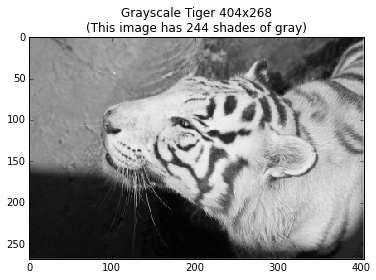

In [1]:
# Show matplotlib inside the notebook
%matplotlib inline 

from scipy.ndimage import imread
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# We will be using 4x4 blocks
blockSize = 4

def showImage(im, title):
    plt.imshow(im, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, interpolation="none")
    plt.title(title + "\n(This image has %d shades of gray)" % len(np.unique(im)))

im = imread("images/tiger.png")
# Let's crop the image so it fits nicely with 4x4 blocks (this will be useful later)
height, width, z = np.shape(im)
height = int(np.floor(height / blockSize) * blockSize)
width = int(np.floor(width / blockSize) * blockSize)
im = im[0:height,0:width,1]

showImage(im, "Grayscale Tiger %dx%d" % (width, height))

We are going to be working on the block at (0,0), but you can pick the one you want.

Pixel values:
[[149 145 146 148]
 [148 145 144 146]
 [147 143 143 145]
 [146 142 141 144]]


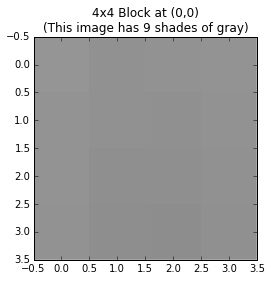

In [2]:
def getBlockAt(im, x, y, blockSize):
    xx = x * blockSize
    yy = y * blockSize
    return im[yy:yy+blockSize][:,xx:xx+blockSize]

block = getBlockAt(im, 0, 0, blockSize)

showImage(block, "4x4 Block at (0,0)")
print("Pixel values:\n%s" % block)

## The Discrete Cosine Transform
Back in part 1, we talked about PVQ being less precise with uniform distributions. Let's decorrolate this block using the discrete cosine transform.

More specifically, we need an integer discrete cosine transform, because in order to achieve lossless PVQ (which we will do) we need the absolute values of the elements of our block to sum to K. If the coefficients are fractional, this will be much more complicated.

Lucky for us, there's a very good implementation of the integer dct in the Daala source code ([right here](https://github.com/xiph/daala/blob/master/src/dct.c)), which I just converted into python. 

In [3]:
def dct(stripe):
    t0 = int(stripe[0])
    t2 = int(stripe[2])
    t1 = int(stripe[1])
    t3 = int(stripe[3])
    
    t3 = t0 - t3
    t2 = t2 + t1
    t2h = t2 >> 1
    t1 = t2h - t1
    t0 = t0 - (t3 >> 1)
    
    t0 = t0 + t2h
    t2 = t0 - t2

    t3 = t3 - ((t1*23013 + 16384) >> 15)
    t1 = t1 + ((t3*21407 + 16384) >> 15)
    t3 = t3 - ((t1*18293 + 8192) >> 14)
    
    res = np.zeros([1,4]).astype(int)
    res[0,0] = t0
    res[0,1] = t1
    res[0,2] = t2
    res[0,3] = t3
    return res

This dct is one-dimensional, to transform our 4x4 block, we need to apply it to every row and every column like so:

In [4]:
def dct2D(block):
    trans = np.zeros([4,4]).astype(int)
    
    trans[0,:] = dct(block[0,:])
    trans[1,:] = dct(block[1,:])
    trans[2,:] = dct(block[2,:])
    trans[3,:] = dct(block[3,:])
    
    trans[:,0] = dct(trans[:,0])
    trans[:,1] = dct(trans[:,1])
    trans[:,2] = dct(trans[:,2])
    trans[:,3] = dct(trans[:,3])
    
    return trans

transform = dct2D(block)
print("Transformed Coeffecients:\n %s" % transform)

Transformed Coeffecients:
 [[580   2   5   2]
 [  5   0   0  -2]
 [  0   0   0  -1]
 [  3   0   0   1]]


As you can see, this is not a uniform distribution anymore. Depending on whom you talk to some people say it's exponential distribution other say it's a Laplacian distribution... Bottom line it's not uniform anymore.

You can get more information about the integer dct [here](https://tools.ietf.org/html/draft-terriberry-netvc-codingtools-00#section-3), and I plan to do a notebook about it in the near future.

## ZigZag Scan
Now we need to convert these coefficients to a 1 dimensional vector in order to apply PVQ, like we did in part 1. As you noticed, most of the energy is in the top left corner (pixel 0,0 is called the DC) the energy drops as you move to the bottom right. This is why, when we convert our coefficients to 1D, we use a zigzag scan.

In [5]:
def raster2Zigzag(b):
    return np.array([b[0,0], b[0,1], b[1,0], b[2,0], 
            b[1,1], b[0,2], b[0,3], b[1,2], 
            b[2,1], b[3,0], b[3,1], b[2,2],
            b[1,3], b[2,3], b[3,2], b[3,3]])

zz = raster2Zigzag(transform)
print("Transformed Coeffecients(zigzag ordering): %s" % zz)

Transformed Coeffecients(zigzag ordering): [580   2   5   0   0   5   2   0   0   3   0   0  -2  -1   0   1]


## DC/AC
The DC (the first coefficient) is scalar quantized, only the AC (the other coefficients) coefficients are _perceptually vector quantized_.

In [6]:
ac = zz[1:]
sumAbsAC = sum(np.abs(ac))
print("AC: %s" % ac)
print("Sum of Absolute AC: %d" % (sumAbsAC))

AC: [ 2  5  0  0  5  2  0  0  3  0  0 -2 -1  0  1]
Sum of Absolute AC: 21


## Gain and Shape
So this is the vector we want to code. I computed the sum of absolute values so we know what K to use for lossless PVQ. Now, we proceed with gain and shape just like in part 1.

In [7]:
def gain(v):
    return np.sqrt(np.dot(v.flatten(1),v.flatten(1)))

def shape(v):
    _gain = gain(v)
    if _gain == 0:
        return v
    else:
        return np.divide(v, gain(v))
    
print("Norm (aka gain) of the AC = %f" % (gain(ac)))
print("Unit vector (aka shape) of AC: %s" % (shape(ac)))

Norm (aka gain) of the AC = 8.544004
Unit vector (aka shape) of AC: [ 0.23408229  0.58520574  0.          0.          0.58520574  0.23408229
  0.          0.          0.35112344  0.          0.         -0.23408229
 -0.11704115  0.          0.11704115]


## Finding the codeword
We can even recycle the algorithm from part 1 to find the code. 

In [8]:
import sys

def findCode(v, k):
    _shape = shape(v)
    length = len(v)

    # Here we spread k of the shape. Without rounding it sums to k, but the elements of the codeword must be integers
    codeword = np.round(_shape/sum(np.abs(_shape))*k).astype(int)
    sa = sum(np.abs(codeword))
    
    if sa != k:
        step = np.sign(k - sa)
        while sa != k:
            minsse = sys.maxsize
            for i in range(0,length): # Iteratively apply step to every element and keep the best.
                codeword[i] = codeword[i] + step 
                sse = sum((_shape.flatten(1) - shape(codeword).flatten(1))**2)
            
                if sse < minsse:
                    bestI = i
                    minsse = sse
                    
                codeword[i] = codeword[i] - step #Undo the step   
            
            codeword[bestI] = codeword[bestI] + step # Perform best step
            sa = sa + step

    return codeword

k = sumAbsAC
codeword = shape(findCode(ac,k))

        
print("Perceptual Vector Quantization of AC (k = %d) = %s " % (k, codeword))


Perceptual Vector Quantization of AC (k = 21) = [ 0.23408229  0.58520574  0.          0.          0.58520574  0.23408229
  0.          0.          0.35112344  0.          0.         -0.23408229
 -0.11704115  0.          0.11704115] 


And there you have it, we "_pvqued_" that 4x4 block.

Well, not quite, we did "lossless quantization", by setting **k** to the sum of the absolute values of the AC, we generated a codebook with the AC as one of its codewords. In other words, that last step did not do anything useful, since our codeword is equal to the shape. 

In [9]:
assert(codeword.all() == shape(ac).all())

# Inverting all the steps
Don't be sad, we are going to quantize something (for real), but for now let's do all the step in reverse to see if we get back our original block.

From the codeword and the gain, we will reconstruct our AC

In [10]:
recon = codeword * gain(ac)
print("Reconstructed zigzag %s" % (recon))

Reconstructed zigzag [ 2.  5.  0.  0.  5.  2.  0.  0.  3.  0.  0. -2. -1.  0.  1.]


Next, we add the DC and convert from zigzag to raster:

In [11]:
def zigzag2raster(b):
    r = np.empty([4,4])
    r[0,0] = b[0]
    r[0,1] = b[1]
    r[1,0] = b[2]
    r[2,0] = b[3]
    r[1,1] = b[4]
    r[0,2] = b[5]
    r[0,3] = b[6]
    r[1,2] = b[7]
    r[2,1] = b[8]
    r[3,0] = b[9]
    r[3,1] = b[10]
    r[2,2] = b[11]
    r[1,3] = b[12]
    r[2,3] = b[13]
    r[3,2] = b[14]
    r[3,3] = b[15]
    return r 

print(np.insert(recon, 0, transform[0,0]))
rebuilt = zigzag2raster(np.insert(recon, 0, transform[0,0]))
print("Original transformed coefficients:\n%s" % transform)
print("Reconstructed transformed coefficients:\n%s" % np.round(rebuilt).astype(int))
assert(rebuilt.all() == transform.all())

[ 580.    2.    5.    0.    0.    5.    2.    0.    0.    3.    0.    0.
   -2.   -1.    0.    1.]
Original transformed coefficients:
[[580   2   5   2]
 [  5   0   0  -2]
 [  0   0   0  -1]
 [  3   0   0   1]]
Reconstructed transformed coefficients:
[[580   2   5   2]
 [  5   0   0  -2]
 [  0   0   0  -1]
 [  3   0   0   1]]


Finally, we use the inverse integer dct to convert back into pixels.

[[149 145 146 148]
 [148 145 144 146]
 [147 143 143 145]
 [146 142 141 144]]
Sum of Absolute Difference: 0.000000
Sum of Squared Error: 0.000000


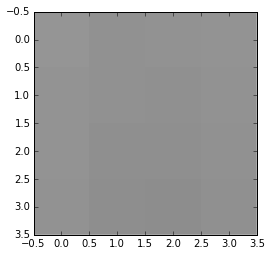

In [12]:
def idct(stripe):    
    t0 = int(stripe[0])
    t1 = int(stripe[1])
    t2 = int(stripe[2])
    t3 = int(stripe[3])
    
    t3 = t3 + ((t1 * 18293 + 8192) >> 14)
    t1 = t1 - ((t3 * 21407 + 16384) >> 15)
    t3 = t3 + ((t1 * 23013 + 16384) >> 15)
    
    t2 = t0 - t2
    t2h = t2 >> 1
    t0 = t0 - (t2h - (t3 >> 1))
    t1 = t2h - t1
    
    res = np.zeros([1,4]).astype(int)
    res[0,0] = t0
    res[0,2] = t2 - t1
    res[0,1] = t1
    res[0,3] = t0 - t3
    
    return res


def idct2D(block):
    itrans = np.zeros([4,4]).astype(int)
    itrans[:,0] = idct(block[:,0])
    itrans[:,1] = idct(block[:,1])
    itrans[:,2] = idct(block[:,2])
    itrans[:,3] = idct(block[:,3])
    
    itrans[0,:] = idct(itrans[0,:])
    itrans[1,:] = idct(itrans[1,:])
    itrans[2,:] = idct(itrans[2,:])
    itrans[3,:] = idct(itrans[3,:])
    
    return itrans

inverse = idct2D(np.round(rebuilt).astype(int))

plt.imshow(inverse, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, interpolation="none")
print(inverse)

def computeError(a, b):
    print("Sum of Absolute Difference: %f" % (sum(abs(a.flatten(1) - b.flatten(1)))))
    print("Sum of Squared Error: %f" % (sum((a.flatten(1) - b.flatten(1))**2)))
    
computeError(inverse, block)

And _Voila!_, the original block.

## Increasing k

>What would have happened for other values of K?

Let's find out:

Sum of the absolute value of the AC: 21.000000
Gain of the AC: 8.544004


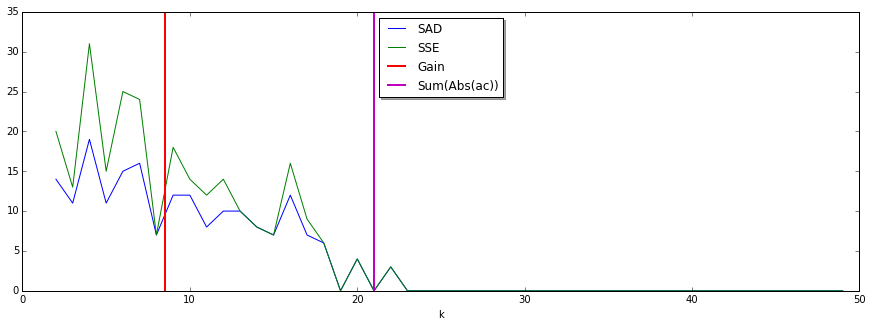

In [13]:
plt.figure(figsize=(15,5)) # Make the plot bigger
sad = []
sse = []
numKs = 50

transform = dct2D(block)
zz = raster2Zigzag(transform)
ac = zz[1:]
for k in range(2,numKs):
    recon = np.round(shape(findCode(ac,k))* gain(ac)).astype(int)
    rebuilt = zigzag2raster(np.insert(recon, 0, transform[0,0]))
    inverse = idct2D(rebuilt)
    sad.append(sum(abs(block.flatten(1) - inverse.flatten(1))))
    sse.append(sum((block.flatten(1) - inverse.flatten(1))**2))
    

sumAbsAC = sum(np.abs(ac).flatten(1))
gainAC = gain(ac) 
plt.plot(range(2,numKs), sad, label='SAD', c="blue")
plt.plot(range(2,numKs), sse, label='SSE', c="green")
plt.plot([gainAC, gainAC], [0, 35], 'r-', label='Gain', lw=2)
plt.plot([sumAbsAC, sumAbsAC], [0, 35], 'm-', label='Sum(Abs(ac))', lw=2)
plt.xlabel("k")
legend = plt.legend(loc='upper center', shadow=True)
print("Sum of the absolute value of the AC: %f" % sumAbsAC)
print("Gain of the AC: %f" % (gainAC))

The previous plot shows the error in SAD and SSE as k increases for one 4x4 block. In red is the gain and in magenta the sum of absolute values (lossless pvq). As in part 1, the error is not monotone decreasing as k increases. However, in this case the error is always 0 passed 22.

## Now, for the main event: Let's PVQ an image!

Sum of Absolute Difference: 0.000000
Sum of Squared Error: 0.000000


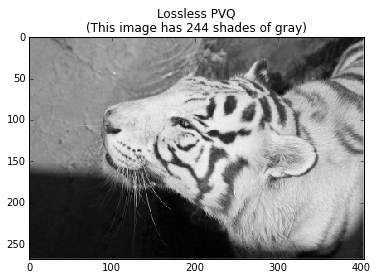

In [14]:
def setBlockAt(im, x, y, blockSize, block):
    xx = x * blockSize
    yy = y * blockSize
    im[yy:yy+blockSize,xx:xx+blockSize] = block
   

im2 = np.zeros((height, width)).astype('uint8')
    
bWidth = int(width / blockSize)
bHeight = int(height / blockSize)
    
for y in range(0, bHeight):
    for x in range(0,bWidth):
        block = getBlockAt(im, x, y, blockSize)
        zz = raster2Zigzag(dct2D(block))
        ac = zz[1:]
        sumAbsAC = sum(abs(ac))
        if sumAbsAC != 0:
            recon = np.round(shape(findCode(ac,sumAbsAC))* gain(ac)).astype(int)
        else:
            recon = ac
        inverse = idct2D(zigzag2raster(np.insert(recon, 0, zz[0])))
        setBlockAt(im2, x, y, blockSize, inverse)

computeError(im, im2)
showImage(im2, "Lossless PVQ")

In the previous example, for every block we used the sum of absolute values of AC as the K, and as you can see we get lossless PVQ.

> Enough with the lossless already!

Fine, you want lossy, let's set **k** to 1.

Sum of Absolute Difference: 12489565.000000
Sum of Squared Error: 4565011.000000
PSNR: 31.881547 dB


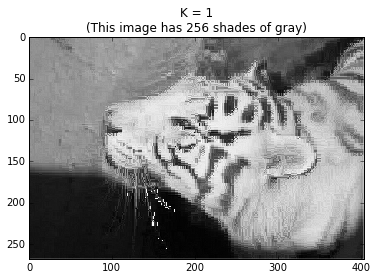

In [15]:
k = 1

def pvqImage(k):
    im2 = np.zeros((height, width)).astype('uint8')
    
    bWidth = int(width / blockSize)
    bHeight = int(height / blockSize)
    
    for y in range(0, bHeight):
        for x in range(0,bWidth):
            block = getBlockAt(im, x, y, blockSize)
            zz = raster2Zigzag(dct2D(block))
            ac = zz[1:]
            sumAbsAC = sum(abs(ac))
            if sumAbsAC != 0:
                recon = np.round(shape(findCode(ac,k))* gain(ac)).astype(int)
            else:
                recon = ac
            inverse = idct2D(zigzag2raster(np.insert(recon, 0, zz[0])))
            setBlockAt(im2, x, y, blockSize, inverse)
    return im2

im2 = pvqImage(k)
showImage(im2, "K = %d" % k)

import math
def psnr(a, b):
    return 10*math.log10((255*255)/(sum((a.flatten(1) - b.flatten(1))**2)/(height * width)))
def computeError(a, b):
    print("Sum of Absolute Difference: %f" % (sum(abs(a.flatten(1) - b.flatten(1)))))
    print("Sum of Squared Error: %f" % (sum((a.flatten(1) - b.flatten(1))**2)))
    print("PSNR: %f dB" % (psnr(a,b)))

computeError(im, im2)

> Wait, this is very strong quantization and you have 256 shades of gray?

We are not quantizing colors, like we did in part one, the quantization is on the transform coefficient.

The worst quantization artifacts are probably the whiskers. Let's slowly improve quality

## Problematic Whiskers

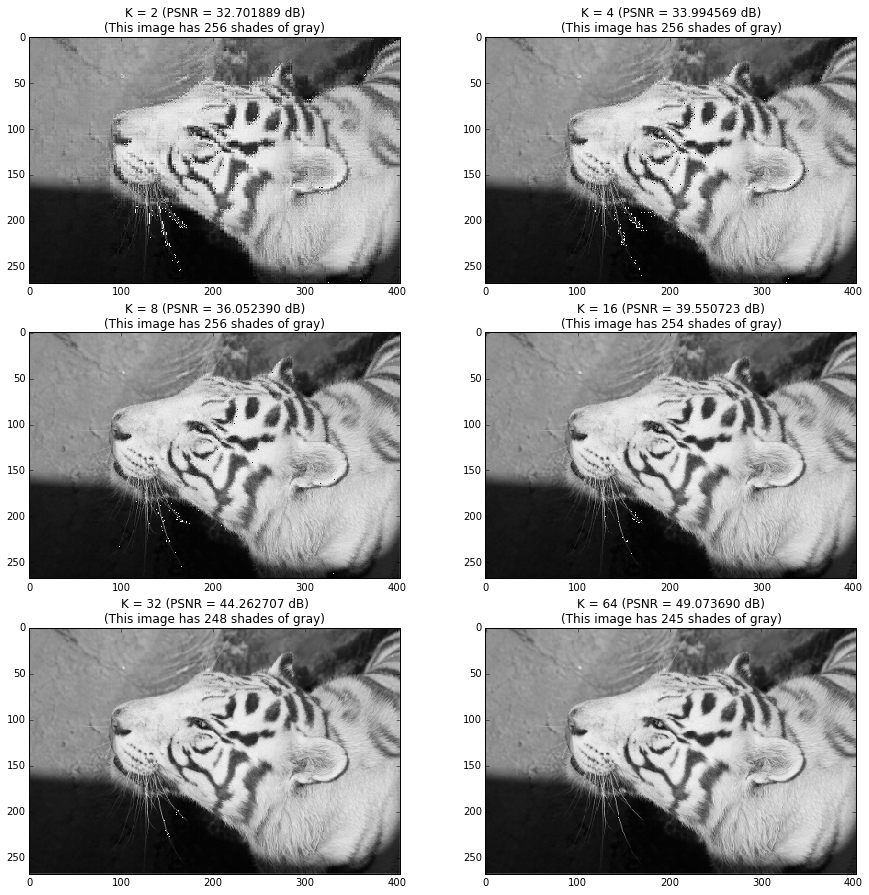

In [16]:
def showImForK(k):
    im2 = pvqImage(k)
    showImage(im2, "K = %d (PSNR = %f dB)" % (k, psnr(im,im2)))
    
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
showImForK(2)

plt.subplot(3,2,2)
showImForK(4)

plt.subplot(3,2,3)
showImForK(8)

plt.subplot(3,2,4)
showImForK(16)

plt.subplot(3,2,5)
showImForK(32)

plt.subplot(3,2,6)
showImForK(64)

As **k** increases the quality increases, but the whiskers remain problematic when **k** is constant.

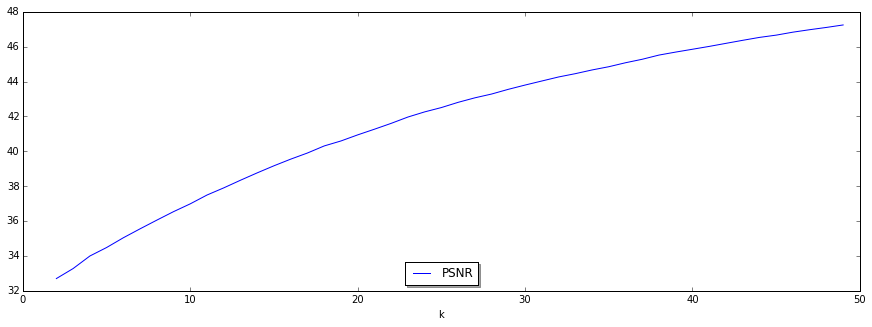

In [53]:
plt.figure(figsize=(15,5))
psnr = []
numKs = 50

for k in range(2,numKs):
    im2 = pvqImage(k)
    mse = sum((im.flatten(1) - im2.flatten(1))**2)/(height * width)
    psnr.append(20*math.log10(255) - 10*math.log10(mse))

plt.plot(range(2,numKs), psnr, label='PSNR')
plt.xlabel("k")
legend = plt.legend(loc='lower center', shadow=True)

#Conclusion
So there you have it, as promised we "_perceptually vector quantized_" an image. As we have seen, before perceptual vector quantization a discrete cosine transform is performed followed by a zigzag scan. All these steps must inversed in order to get the "PVQued" image. As in part 1, you get to pick and chose **k**, a low value of **k** will result in a small codebook and little precision. Increasing the value of **k** improves the precision (up to a certain point).

**Let me know what you want to see in future Daala notebooks (Twitter @LT_Pragmatic).**

# Further reading
This work is based on:
 * The [Perceptual Vector Quantization demo](https://people.xiph.org/~jm/daala/pvq_demo/)
 * The paper [Perceptual Vector Quantization for Video Coding](http://jmvalin.ca/papers/spie_pvq.pdf) by Jean-Marc Valin and Timothy B. Terriberry
 * The paper [￼A Pyramid Vector Quantizer](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1057198) by Thomas R. Fischer